In [1]:
# Source: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [3]:
# Load the data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

# g = sns.countplot(Y_train)

Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
# Set the random seed
random_seed = 2

In [11]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

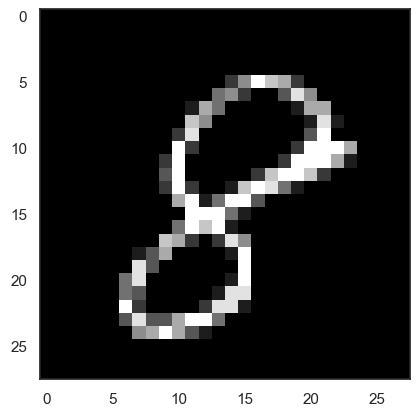

In [12]:
# Some examples
g = plt.imshow(X_train[0][:,:,0], cmap='gray')

In [13]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/Users/olileh/.pyenv/versions/3.12.0/envs/neural_net_example/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Define the optimizer
optimizer = RMSprop(
    learning_rate=0.001,
    rho=0.9,
    epsilon=1e-08
)

In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
epochs = 2 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [18]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [19]:
# Fit the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/2


/Users/olileh/.pyenv/versions/3.12.0/envs/neural_net_example/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 - 84s - 192ms/step - accuracy: 0.8631 - loss: 0.4212 - val_accuracy: 0.9648 - val_loss: 0.1224 - learning_rate: 0.0010
Epoch 2/2


/Users/olileh/.pyenv/versions/3.12.0/envs/neural_net_example/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
2024-07-05 14:42:06.107200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/olileh/.pyenv/versions/3.12.0/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


439/439 - 3s - 7ms/step - accuracy: 0.9186 - loss: 0.2034 - val_accuracy: 0.9752 - val_loss: 0.0827 - learning_rate: 0.0010


In [20]:
import numpy as np
from PIL import Image, ImageOps

def predict(image_paths):
    image_arrays = []
    for image_path in image_paths:
        # Load and preprocess the image
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image = ImageOps.invert(image)

        # Resize to 28x28 pixels
        image = image.resize((28, 28))

        # Convert to a numpy array and normalize
        image_array = np.array(image)
        image_array = image_array / 255.0
        
        # Reshape to match the input shape of the model (1, 28, 28, 1)
        image_array = image_array.reshape(1, 28, 28, 1)
        
        image_arrays.append(image_array)
        
    # Convert list to numpy array and adjust shape to (n, 28, 28, 1)
    image_arrays = np.concatenate(image_arrays, axis=0)
    
    # Predict the class using the trained model
    predictions = model.predict(image_arrays, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    output = predicted_classes.tolist()
    #output[0]=8
    return output

In [21]:
image_paths = ['six.jpg', 'six.jpg']  # Replace with the path to your image
predicted_class = predict(image_paths)
print(f'The predicted class is: {predicted_class}')

The predicted class is: [6, 6]
